<center><h1><b>Practical #2</b></h1>
<h2><b>GANs: Generative Adversarial Networks</b><br/>
<b>for Image Generation</b></h2></center>

GANs use 2 neural networks trained on opposing loss functions: a **generator** which aims to produce data that is as similar as possible to the training data, and a **discriminator** which aims to distinguish between the real and the generated data. Please see lecture 4 for more details on how they work.

<center><img width=600 src="https://drive.google.com/uc?id=1Z9PwIwUNjo9X1KxVHxCYe3YLcQboG6hq"></center>

<br/>

During today's practical you will:
1. Use given code to build the structure of the 2 networks, put together the GAN model and training loop and load datasets. 
2. Train the GAN and observe output results.
3. Follow-up with exercises exploring the possibilities for customising the GAN, as well as the usage of pre-trained models and ready-made interactive applications using GANs.


# Getting started

Create your own Jupyter notebook in Google Colab (or download a copy of this one so that you can edit it). Make sure that you enable GPU for the session (`Edit -> Notebook Settings -> Hardware accelerator -> GPU`). If you've made your own one, copy the code structure given here. Otherwise, just fill in the missing code.

Next, import `tensorflow` into your project and check that everything is set up appropriately. The expected output from the following block of code is the name of the GPU (if nothing is printed after "Found GPU at:", then you don't have GPU access, please notify a demonstrator).

We'll also perform the other required imports in this step.

In [2]:
#@title Imports

import tensorflow as tf

import numpy as np
from tqdm.autonotebook import tqdm
from IPython import display
# import pandas as pd
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)

Found GPU at: /device:GPU:0
2.7.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Data

The first thing we'll do in today's session is to retrieve a data set of images. The GAN that we will train next on this data set will output similar images. You can experiment with different options, but for now choose one of the following and store it in a variable:


*   **MNIST**: 60000+10000 images of hand-drawn digits, split in 10 categories (0, 1, 2 etc.). Size 28x28, grayscale values 0-255. `tf.keras.datasets.mnist` ([More info](http://yann.lecun.com/exdb/mnist/))
*   **Fashion MNIST**: 60000+10000 images of clothing items, split in 10 categories (top, trouser, pullover etc.). Size 28x28, RGB values 0-255. `tf.keras.datasets.fashion_mnist` ([More info](https://github.com/zalandoresearch/fashion-mnist))
*   **Cifar10**: 50000+10000 images of objects, split in 10 categories (plane, bird, cat, dog etc.). Size 32x32, RGB values 0-255. `tf.keras.datasets.cifar10` ([More info](https://www.cs.toronto.edu/~kriz/cifar.html))

The `load_data()` function applied to any of these datasets returns 4 NumPy arrays in 2 2-tuples:
* `train_images` and `train_labels`: arrays which contain the training dataset, used by the GAN to learn. All images are labelled based on their category.
* `test_images` and `test_labels`: arrays which contain the test set, to check the trained model's accuracy (and other statistics). We won't use this, we'll simply group train and test datasets together.
---

<br/>

## <h1><img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-1:</b> Load a dataset</h1> 

<b>Choose</b> a dataset from the drop-down menu, which is then loaded into the 4 variables mentioned above: (train_images, train_labels), (test_images, test_labels). The images and labels are then grouped together into a single dataset.

<i>Optional</i>: check the code to understand how the dataset is loaded.

In [3]:
dataset_choice = "cifar10"  # @param ["mnist", "fashion_mnist", "cifar10"]

switcher = {
    "mnist": tf.keras.datasets.mnist,
    "fashion_mnist": tf.keras.datasets.fashion_mnist,
    "cifar10": tf.keras.datasets.cifar10
}
dataset = switcher[dataset_choice]
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

train_images = np.concatenate((train_images, test_images))
train_labels = np.concatenate((train_labels, test_labels))

170508288/170498071 [==============================] - 2s 0us/step


All datasets discussed here include several categories of objects. It will be easier for our GAN to learn to generate good images if we narrow down the *type* of images we're asking it to learn about. This is not necessary, but it could improve performance in the short tests we'll run here.

## <h1><img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-2:</b> Select data category</h1> 

Please **run** the following block of code, use the drop-down that pops up to select the category you wish to use (from the previously selected dataset) and then run the following cell as well. These set up variables for use later on.

In [4]:
#@title Category chooser

import ipywidgets as widgets

categories = {
    "mnist": ["all", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "fashion_mnist": ["all", "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],
    "cifar10": ["all", "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
}

category_picker = widgets.Dropdown(options=categories[dataset_choice], value='all')

category_picker

Dropdown(options=('all', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'tru…

In [5]:
#@title Process chosen category

category = categories[dataset_choice].index(category_picker.value)-1

if category >= 0:
  filter_train = np.where(train_labels == category)
  filter_train = filter_train[0]
  train_images = train_images[filter_train, :,:]

print(train_images.shape)

(60000, 32, 32, 3)


## Display training images

Display some of the images to see what you've got.

In [6]:
#@title Helper function for displaying images

def show_images(images):
    if len(images.shape) > 3 and images.shape[3] == 1:
        if tf.is_tensor(images):
            images = images.numpy()
        images = np.squeeze(images, axis=3)

    num_images = len(images)
    fig, cells = plt.subplots(ncols=num_images, nrows=1, figsize=(2 * num_images, 2))
    for cell_num in range(num_images):
        cells[cell_num].matshow(images[cell_num])
        cells[cell_num].axis('off')
    plt.show()

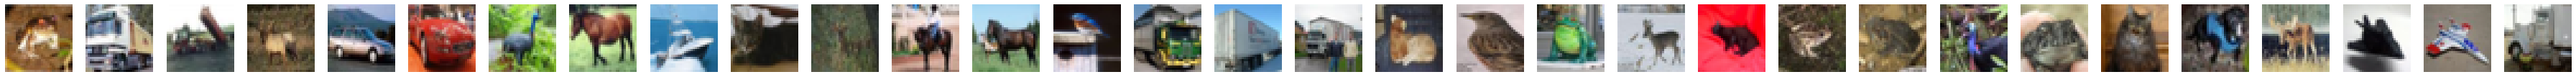

In [7]:
#@title Display

# Show only some of the images
n_images =  32#@param{type: "integer"}
images_display = train_images
if n_images > 0:
    images_display = images_display[:n_images]

# Display!
show_images(images_display)

## Data pre-processing

Let's keep track of some parameters related to our dataset. We recommend to keep `BATCH_SIZE` at 512, but you can play around with this.

In [8]:
#@title Dataset parameters

# default: 512
BATCH_SIZE = 512 # @param {type:"slider", min:128, max:1024, step:128}
N_CHANNELS = (train_images.shape[-1] if len(train_images.shape)>3 else 1)
TRAIN_BUF = len(train_images)
IMG_SIZE = len(train_images[0])
DIMS = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)

print("Batch size: {} \nTraining set size: {}\
       \nImage Dimensions: {} \n# Train batches: {}".format(
            BATCH_SIZE, TRAIN_BUF, DIMS, N_TRAIN_BATCHES
        )
)

Batch size: 512 
Training set size: 60000       
Image Dimensions: (32, 32, 3) 
# Train batches: 117


### <h1><img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-3:</b> Normalize data</h1> 

Next we need to normalise the data between 0 and 1. To do this, first apply the `.astype("float32")` function to the training dataset. Next, given that the colour layers go between 0 and 255, divide by 255.0 the train_images variable. **Implement** the code needed to achieve this.

**Note**: Data should be reshaped appropriately, using e.g. `.reshape(train_images.shape[0], IMG_SIZE, IMG_SIZE, N_CHANNELS)`

In [9]:
#@title Normalize data
# TODO
train_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], IMG_SIZE, IMG_SIZE, N_CHANNELS) / 255.0

Next, we create batches for training.

In [10]:
#@title Batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

And that's it! our data is all set up and ready to be fed into the GAN. 

# Generator Network

Let's start setting up our GAN, beginning with the structure of the generator network. The input for the generator is a vector of noise; from this, it will generate an image. The images will be random noise in the beginning, but the results will improve over time as the network is trained.

We'll need the following layers for the generator network structure and an [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam):
* **[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)**: A densely connected layer, the first layer of our network.
* **[Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)**: A convolutional layer that also upscales the image.
* **[Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape)**: Used to change the shape of a vector.

When you run the following code, it will output a summary of the network structure. The last layer output will have the same shape as the training dataset.

In [11]:
#@title Set up generator network structure


# default: "relu"
activation_l0 = "relu" #@param{type: "string"}
# default: "relu"
activation_l2 = "relu" #@param{type: "string"}
# default: "relu"
activation_l3 = "relu" #@param{type: "string"}
# default: "sigmoid"
activation_l4 = "sigmoid" #@param{type: "string"}

n_stride = 2  # factor to scale image up by in each convolution layer
n_layers_stride = 2  # number of layers scaling the image up
n_smallest_dim = IMG_SIZE//(n_stride*n_layers_stride)
seed_size = IMG_SIZE * (2 ** (n_layers_stride-1)) * N_CHANNELS

# Generator structure, 5 layers: Dense, Reshape, 3xConvolutionTranspose
generator = [
    tf.keras.layers.Dense(units=n_smallest_dim * n_smallest_dim * seed_size, activation=activation_l0),
    tf.keras.layers.Reshape(target_shape=(n_smallest_dim, n_smallest_dim, seed_size)),
    tf.keras.layers.Conv2DTranspose(
        filters=seed_size, kernel_size=3, strides=(n_stride, n_stride), padding="SAME", activation=activation_l2
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=seed_size/2, kernel_size=3, strides=(n_stride, n_stride), padding="SAME", activation=activation_l3
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=N_CHANNELS, kernel_size=3, strides=(1, 1), padding="SAME", activation=activation_l4
    ),
]

#-- Optimiser
# default: 0.001
opt_learning_rate = 0.0001  #@param{type:"raw"}
# default: 0.5
opt_beta = 0.4 #@param{type:"raw"}
gen_optimizer = tf.keras.optimizers.Adam(opt_learning_rate, beta_1=opt_beta)

# Build the network
gen = tf.keras.Sequential(generator)
gen.build([train_images.shape[0], 1, 1, seed_size])  # specifies input shape

# Print network summary
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (60000, 1, 1, 12288)      2371584   
                                                                 
 reshape (Reshape)           (60000, 8, 8, 192)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (60000, 16, 16, 192)     331968    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (60000, 32, 32, 96)      165984    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (60000, 32, 32, 3)       2595      
 ranspose)                                                       
                                                        

# Discriminator Network

Next, let's define the structure of the discriminator network. What this network does is it receives an image, and it needs to decide whether the image is real or fake. So the output of this network is binary, real/fake. Some more concepts:

*   **[InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)**: A layer of a specific size, with input shape specified.
*   **[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)**: A convolutional layer.
*   **[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)**: Used to reshape a multi-dimensional vector into a 1D vector.
*   **[RMSProp optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)**

When you run the following code, it will also output a summary of the structure of the discriminator network.


In [12]:
#@title Set up discriminator network structure

# default: "relu"
activation_l1 = "relu" #@param{type: "string"}
# default: "relu"
activation_l2 = "relu" #@param{type: "string"}

# Discriminator structure: 5 layers, Input + Convolutionx2 + Flatten + Dense
discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=seed_size/2, kernel_size=3, strides=(n_stride, n_stride), activation=activation_l1
    ),
    tf.keras.layers.Conv2D(
        filters=seed_size, kernel_size=3, strides=(n_stride, n_stride), activation=activation_l2
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]


#-- Optimiser
# default: 0.005
opt_learning_rate = 0.0001  #@param{type:"raw"}
disc_optimizer = tf.keras.optimizers.RMSprop(opt_learning_rate)

# Build the network
disc = tf.keras.Sequential(discriminator)
disc.compile(loss='binary_crossentropy', optimizer= disc_optimizer , metrics = ['accuracy'])
disc.build(DIMS)  # specifies input shape

# Print network summary
disc.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 192)         166080    
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9409      
                                                                 
Total params: 178,177
Trainable params: 178,177
Non-trainable params: 0
_________________________________________________________________


# Putting it all together: GAN

In this example, we set up the custom training loop for the GAN within a keras Model subclass. This will group together our 2 networks, and, during training, it will have the generator network generate images, which are then run through the discriminator together with an equal sample of real images. The results of this process are used to update both networks so that the generator learns to fool the discriminator into believing the fake images generated are real, while the discriminator learns to better distinguish real and fake images.

Simply run the next block of code to put this together, and check that you understand the logic.

In [13]:
#@title Set up the GAN as a Keras model object.

class GAN(tf.keras.Model):
    """ 
    A basic GAN class. Extends tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = self.gen
        self.disc = self.disc

    def call(self, x):
        return self.gen(x)

    def generate(self, z):
        """
        Run input vector z through the generator to create fake data.
        """
        return self.gen(z)

    def discriminate(self, x):
        """
        Run data through the discriminator to label it as real or fake.
        """
        return self.disc(x)

    def compute_loss(self, x):
        """ 
        Passes through the network and computes loss for given data.
        """
        # Generate a random vector seed from a uniform distribution
        seed = tf.random.normal([x.shape[0], 1, 1, self.seed_size])

        # Use the seed to generate a fake data set with the generator network.
        fakes = self.generate(seed)

        # Use the discriminator network to obtain labels for both the generated data (x_gen) and the real data (x)
        logits_reals = self.discriminate(x)
        logits_fakes = self.discriminate(fakes)

        # Discriminator loss, looking at correctly labeled data
        # Losses of the real data with correct label "1"
        disc_real_loss = gan_loss(logits=logits_reals, is_real=True)
        # Losses of the fake data with correct label "0"
        disc_fake_loss = gan_loss(logits=logits_fakes, is_real=False)
        # The discriminator loss is the sum of the 2 previous values
        disc_loss = disc_fake_loss + disc_real_loss

        # Generator loss, looking at the fake data labeled as real ("1")
        gen_loss = gan_loss(logits=logits_fakes, is_real=True)

        # Return losses
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ 
        Passes through the network and computes gradients.
        """
        ### Pass x through network and compute losses
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # Compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        """
        Apply given gradients to both networks.
        """
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x):
        """
        Train the GAN! 
        """
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """
    Computes cross entropy between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    # Returns loss calculation
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)


# Set up the model

model = GAN(
    gen = gen,
    disc = disc,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    seed_size = seed_size
)

# GAN Training

While the GAN model set up takes care of a training iteration, we need to repeat this for several epochs and observe how the quality of images generated improves over time. The training is done in batches at each epoch, using the `tqdm` library to create these according to variables defined earlier and display progress.

Once the model is trained (or even before!), we can run it! This can be done directly by using the generator network to generate new images, or by using the `predict()` function on the GAN model, which implicitly calls the generator network. The input here is a random noise vector, and the output is a set of generated images.

Epoch: 199


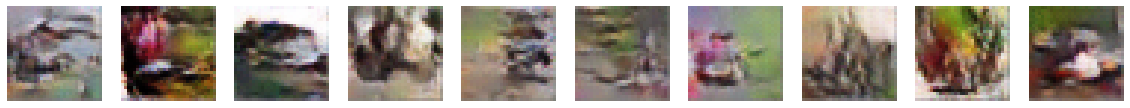

In [14]:
#@title Set up the training loop and run.

# default: 50
n_epochs =  200# @param{type: "integer"} 

# losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

for epoch in range(n_epochs):

    # Train the model
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)

    # At this point we could also test the model, compute losses and display them during training (if we'd kept training and test images separate)
    # loss = []
    # for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
    #     loss.append(model.compute_loss(train_x))
    # losses.loc[len(losses)] = np.mean(loss, axis=0)

    # Display epoch and images generate at this point in training
    display.clear_output()  # This line clears output between epochs
    # print(
    #     "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
    #         epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
    #     )
    # )
    print("Epoch: {}".format(epoch))
    generated_images = model.gen(tf.random.normal(shape=(10, seed_size)))
    show_images(generated_images)

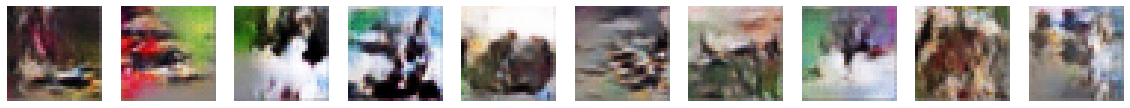

In [15]:
#@title Run the (trained) model

# Running with random input to generate images
samples = model.predict(tf.random.normal(shape=(10, 1, 1, seed_size)))
show_images(samples)


# Saving and Loading models

In this example we're subclassing the keras Model class and adding several variables and methods to it to facilitate the definition of the custom training loop typical in GANs. Because of this, tensorflow does not provide an easy way to save the whole GAN model after it's been trained.

However, we do have defined 2 networks within our GAN, while the GAN model simply puts them together and takes care of the appropriate training loop. As a result, what we *can* do is **save** the 2 networks individually. Then, when we **load** them, either use the generator network directly to generate images, or put the 2 networks back together in the GAN class for more training or testing as needed.

We're going to be saving these models in Google Drive. So, first thing to do is mount the drive and choose file paths within it.

In [16]:
#@title Save model to GDrive

from google.colab import drive
drive.mount('/content/gdrive')

gen_save_name = 'gen' #@param{type: 'string'}
gen_save_name += '.tf'  # Set extension separately
disc_save_name = 'disc' #@param{type: 'string'}
disc_save_name += '.tf' # Set extension separately

path = 'My Drive/Work/Colab/' #@param{type: 'string'}
full_path_g = F"/content/gdrive/{path}{gen_save_name}" 
full_path_d = F"/content/gdrive/{path}{disc_save_name}" 

Mounted at /content/gdrive


Next, we save the 2 networks using the `save(path, save_format='tf')` function on the model objects themselves.

In [17]:
#@title Save model

# tf.saved_model.save(gen, full_path_g)
gen.save(full_path_g, save_format='tf')
disc.save(full_path_d, save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Work/Colab/gen.tf/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Work/Colab/disc.tf/assets


We can then load these models (potentially in a different notebook altogether!) using the `tf.keras.models.load_model(path)` function.

In this example we're putting the 2 networks together into the GAN model and use it to generate some images. The quality of the images obtained should be the same as after training.

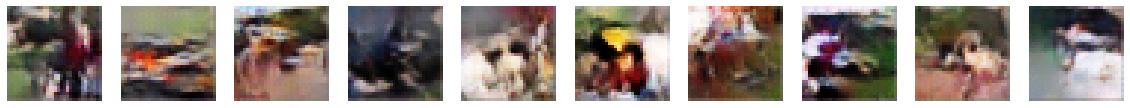

In [18]:
#@title Load model and generate images
gen2 = tf.keras.models.load_model(full_path_g)
disc2 = tf.keras.models.load_model(full_path_d)

# Put together GAN model with the loaded networks
model = GAN(
    gen = gen2,
    disc = disc2,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    seed_size = seed_size
)

# Generate some images!
samples = model.predict(tf.random.normal(shape=(10, 1, 1, seed_size)))
show_images(samples)

# Exercises

## <img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-4:</b> Customize the network

1. You will find several **parameters** in this notebook, highlighted on the right side of the code blocks (e.g. learning rate for the optimisers). If you modify some of these values, how do you think it will impact the images generated by the GAN? 
  <ol type="a">
  <li>Are they better, or worse? </li>
  <li>Does it need more or less training time to start generating good images?  </li>
  <li>Try some different values and check if your intuition is correct.</li>
  </ol>

2. The **structure** of the networks can also be modified.  

  <ol type="a">
  <li>Look into the different activation functions available and check if others work better or worse in this context.</li>
  <li>What other optimisers could be used for better performance?</li>
  <li>What about the layers? Would adding <i>batch normalization</i> or <i>dropout</i> make a difference? How can you add these to the network structures? (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">Hint</a>)  </li>
  </ol>

## <img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-5:</b> Experiment with pre-trained models

1. Copy these trained [generator model](https://drive.google.com/drive/folders/1MKuKWB1QXNcKbenmPRN0QWSkhbJAw4iH?usp=sharing) and [discriminator model](https://drive.google.com/drive/folders/1oWNuQKf_PdjFDxZmuuzFfdlhyMVPm1cB?usp=sharing) to your own GDrive. The models were trained on the fashion-MNIST (tops) dataset with the same default settings found in this notebook, for 500 epochs. What kind of images does the resultant GAN generate? 

2. If you gave it a different dataset (e.g. fashion-MNIST sandals) and trained it for 50 more epochs, does it output images that look like tops, sandals, or a mash-up of the 2?


## <img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-6:</b> Load your own data

1. Use the code below to load your own images from your Google Drive into `train_images` and `test_images` variables (the code uses a 80% - 20% split between training and test images). Alternatively, you can write your own code to load images from your own machine.
2. Run the rest of the code in the notebook again (from the data pre-processing step) to train the GAN with your own images instead and observe output generated. You may need to adjust some parameters, such as the batch size, so that everything works correctly with your data.

**Note**: make sure all of your images have the same size.

In [19]:
# @title Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
#@title Unzip file (if using zip file)

# The path to a zip of images
path = 'My Drive/Work/Colab/' #@param{type: 'string'}

# File name
zip_file_name = "images" #@param{type: 'string'}
full_path = '/content/gdrive/' + path + filename + ".zip"
full_path_dir = '/content/gdrive/' + path + filename + "/" 
   
!unzip full_path -d full_path_dir

unzip:  cannot find or open full_path, full_path.zip or full_path.ZIP.


In [22]:
#@title Setting paths to folder (if NOT using zip file)

path = 'My Drive/Work/Colab/' #@param{type: 'string'}
folder_name = "images" #@param{type: 'string'}
full_path_dir = '/content/gdrive/' + path + folder_name + "/" 

In [23]:
#@title Open directory containing images and load data

from PIL import Image
import os

data = []

for filename in os.listdir(full_path_dir):
    image = Image.open(full_path_dir + filename)
    data.append(np.asarray(image))

train_images = np.array(data)
print(train_images.shape)

FileNotFoundError: ignored

## <img width=30 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Bright_green_checkbox-checked.svg/1024px-Bright_green_checkbox-checked.svg.png"> <b>TODO-7:</b> Test online GAN applications

1. [GAN Lab](https://poloclub.github.io/ganlab/) offers a browser-based visualisation of a GAN training over time. Play around with the settings (including editting the network structure by clicking the pen icon next to the "Model Overview Graph" in the top-left corner) and observe the quality of the output.
2. [Pix2Pix-TF](https://affinelayer.com/pixsrv/) is a tensorflow implementation of Pix2Pix. The online demo shows how simple sketches can be transformed into cat pictures, buildings, shoes or bags.
3. [GANpaint](http://gandissect.res.ibm.com/ganpaint.html?project=churchoutdoor&layer=layer4) shows how GANs can be used to add elements into an existing image.
2. [Pix2Vox](https://github.com/maxorange/pix2vox) is an open-source application which uses GANs to generate 3D models from simple sketches. You can download it and test what type of models you can make it generate.


# Further reading

- Ways to improve GAN performance: https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b

## Related tutorials

Some of the materials in this practical were based on the following tutorials:

* Ander Fernandez Jauregui, [How to code GAN in Python](https://anderfernandez.com/en/blog/how-to-code-gan-in-python/)
* Tim Sainburg, [GAN Fashion-MNIST](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb)
* [TF-GAN tutorial](https://colab.research.google.com/github/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb)